# Predicting Whether a Spotify Song is Popular or Not
### Chris Tarzian
### https://www.kaggle.com/datasets/danield2255/data-on-songs-from-billboard-19992019

In [55]:
import pandas as pd
import numpy as np
import re

import nltk

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification

from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [56]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [102]:
spotifydf1 = pd.read_csv("spotifydataset_1999_2019.csv", index_col=False)

## Data Processing

In [103]:
spotifydf = spotifydf1
spotifydf = spotifydf.drop(columns={'Unnamed: 0'})

In [104]:
spotifydf['Explicit'] = spotifydf['Explicit'].map({True: 0, False: 1})

In [106]:
spotifydf.drop_duplicates(inplace=True)

In [108]:
print("Popularity Mean Score:", spotifydf.Popularity.mean())

Popularity Mean Score: 20.249895110537356


In [61]:
spotifydf.Popularity.value_counts()

0     12581
1      5533
2      5156
3      4950
4      4353
      ...  
85        3
91        3
88        2
89        2
90        1
Name: Popularity, Length: 92, dtype: int64

In [62]:
spotifydf = spotifydf.loc[(spotifydf['Popularity'] > 5) & (spotifydf['Popularity']  <= 81)]

In [63]:
spotifydf.Popularity.value_counts()

6     3593
8     3549
10    3527
7     3509
9     3493
      ... 
77      53
78      35
79      32
81      25
80      20
Name: Popularity, Length: 76, dtype: int64

In [64]:
## song considered popular if score greater than or equal to 50, score of 1
## song considered non-popular if score less than 50, score of 0

def pop_code(row):  
    if row['Popularity'] < 50:
        return 0
    elif row['Popularity'] >= 50:
        return 1

In [65]:
spotifydf['Popularity_Type'] = spotifydf.apply(lambda row: pop_code(row), axis=1)

In [66]:
spotifydf = spotifydf[['Name','Artist', 'Album', 'Popularity_Type', 'Acousticness','Danceability', 'Duration', 'Energy', 'Explicit','Instrumentalness', 'Liveness', 'Loudness', 'Mode', 'Speechiness', 'Tempo', 'TimeSignature', 'Valence']]

In [67]:
spotifydf.head()

,Name,Artist,Album,Popularity_Type,Acousticness,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,TimeSignature,Valence
0,Welcome All Again,Collective Soul,Collective Soul (Deluxe Version),0,0.000728,0.520,234947,0.904,1,0.010300,0.0634,-5.030,1,0.0309,106.022,4,0.365
1,Fuzzy,Collective Soul,Collective Soul (Deluxe Version),0,0.018200,0.581,239573,0.709,1,0.000664,0.1740,-4.909,1,0.0282,120.027,4,0.408
2,Dig,Collective Soul,Collective Soul (Deluxe Version),0,0.000473,0.572,198400,0.918,1,0.000431,0.0977,-3.324,0,0.0559,144.061,4,0.370
3,You,Collective Soul,Collective Soul (Deluxe Version),0,0.000970,0.596,231453,0.661,1,0.000033,0.1130,-5.051,1,0.0254,111.975,4,0.183
4,My Days,Collective Soul,Collective Soul (Deluxe Version),0,0.000036,0.520,222520,0.808,1,0.000010,0.0800,-4.553,0,0.0318,92.721,4,0.666


In [68]:
spotifydf.Popularity_Type.value_counts()

0    108884
1      9558
Name: Popularity_Type, dtype: int64

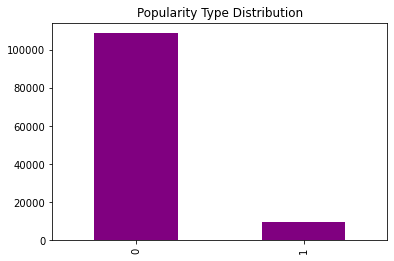

In [69]:
spotifydf.Popularity_Type.value_counts().plot(kind='bar', title = 'Popularity Type Distribution', color = 'purple');

In [70]:
spotifydf.corr()

,Popularity_Type,Acousticness,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,TimeSignature,Valence
Popularity_Type,1.000000,-0.052349,0.031074,0.008887,0.037893,-0.039797,-0.030834,-0.069750,0.077043,-0.019031,-0.032319,0.017065,0.017765,-0.005839
Acousticness,-0.052349,1.000000,-0.218938,-0.149520,-0.691651,0.174251,0.022101,-0.009319,-0.572643,0.092203,-0.048950,-0.154225,-0.195964,-0.191688
Danceability,0.031074,-0.218938,1.000000,-0.060863,0.105557,-0.273213,-0.138431,-0.216576,0.166066,-0.091423,0.200288,-0.123616,0.177599,0.470675
Duration,0.008887,-0.149520,-0.060863,1.000000,0.082833,0.047615,0.105683,0.099539,0.067253,-0.050914,-0.109970,0.015263,0.030449,-0.160839
Energy,0.037893,-0.691651,0.105557,0.082833,1.000000,-0.125014,-0.042796,0.172232,0.757071,-0.083141,0.096183,0.192297,0.200323,0.338542
Explicit,-0.039797,0.174251,-0.273213,0.047615,-0.125014,1.000000,0.118205,-0.010444,-0.131981,0.120310,-0.502438,0.035712,-0.073798,-0.059177
Instrumentalness,-0.030834,0.022101,-0.138431,0.105683,-0.042796,0.118205,1.000000,-0.017823,-0.224362,-0.036031,-0.112577,0.007932,-0.034219,-0.152948
Liveness,-0.069750,-0.009319,-0.216576,0.099539,0.172232,-0.010444,-0.017823,1.000000,0.017036,0.001519,0.137468,-0.001626,-0.004426,-0.043336
Loudness,0.077043,-0.572643,0.166066,0.067253,0.757071,-0.131981,-0.224362,0.017036,1.000000,-0.050848,-0.019178,0.146205,0.171806,0.219442
Mode,-0.019031,0.092203,-0.091423,-0.050914,-0.083141,0.120310,-0.036031,0.001519,-0.050848,1.000000,-0.117136,0.018553,-0.022952,-0.029318


<IPython.core.display.Javascript object>

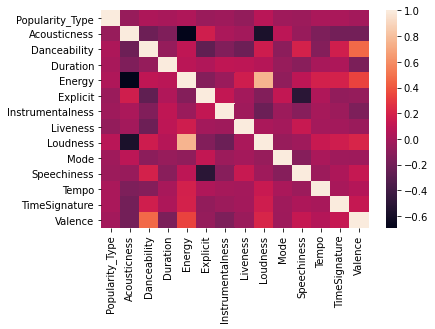

In [71]:
corr = spotifydf.corr()
sns.heatmap(corr);

In [72]:
spotifydf_rf = spotifydf.iloc[:,3:]
spotifydf_rf.groupby('Popularity_Type').mean()

,Acousticness,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,TimeSignature,Valence
Popularity_Type,,,,,,,,,,,,,
0,0.259774,0.572364,234700.118126,0.644745,0.795948,0.057658,0.258123,-7.894165,0.688632,0.113836,119.667912,3.917371,0.497796
1,0.203661,0.591230,237651.831764,0.676446,0.736556,0.036572,0.198161,-6.779031,0.656204,0.097929,121.568908,3.943189,0.492701


## Machine Learning

#### Getting data ready for modeling

In [73]:
## Normalization of specific variables
cols_to_norm = ['Tempo','Duration', 'Loudness','TimeSignature']
spotifydf_rf[cols_to_norm] = spotifydf_rf[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [74]:
spotifydf_rf = spotifydf_rf[['Popularity_Type','Loudness', 'Energy', 'Danceability', 'Liveness', 'Acousticness']]

In [75]:
y = spotifydf_rf['Popularity_Type']
X = spotifydf_rf.drop(columns=['Popularity_Type'])

### Random Forest

In [76]:
weights = {0:1.0, 1:2.0}

In [77]:
SRF = RandomForestClassifier(n_estimators=100, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SRF model
scores = cross_validate(SRF, X, y, scoring=scoring, cv=cv)

In [78]:
one_f1_score = mean(scores['test_f1'])
one_recall_score = mean(scores['test_recall'])
one_precision_score = mean(scores['test_precision'])

print('Mean F1: %.3f' % one_f1_score)
print('Mean Recall: %.3f' % one_recall_score)
print('Mean Precision: %.3f' % one_precision_score)

Mean F1: 0.128
Mean Recall: 0.071
Mean Precision: 0.633


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
#Train SRF
SRF.fit(X_train, y_train)
#SRF prediction result
y_pred = SRF.predict(X_test)
print(classification_report(y_test, y_pred))
rf_recall_score = metrics.recall_score(y_test, y_pred)
rf_precision_score = metrics.precision_score(y_test, y_pred)
rf_f1_score = metrics.f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27221
           1       0.57      0.06      0.12      2390

    accuracy                           0.92     29611
   macro avg       0.75      0.53      0.54     29611
weighted avg       0.90      0.92      0.89     29611



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

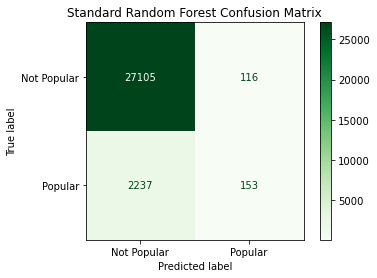

In [80]:
#Create confusion matrix
fig = plot_confusion_matrix(SRF, X_test, y_test, display_labels=['Not Popular', 'Popular'], cmap='Greens')
plt.title('Standard Random Forest Confusion Matrix')
plt.show()

### Balanced Random Forest

In [81]:
BRFC = BalancedRandomForestClassifier(n_estimators=100, random_state=2)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate BRFC model
scores2 = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)

In [82]:
two_f1_score = mean(scores2['test_f1'])
two_recall_score = mean(scores2['test_recall'])
two_precision_score = mean(scores2['test_precision'])

print('Mean F1: %.3f' % two_f1_score)
print('Mean Recall: %.3f' % two_recall_score)
print('Mean Precision: %.3f' % two_precision_score)

Mean F1: 0.190
Mean Recall: 0.633
Mean Precision: 0.112


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
#Train BRFC
BRFC.fit(X_train, y_train)
#BRFC prediction result
y_pred = BRFC.predict(X_test)
print(classification_report(y_test, y_pred))
brf_recall_score = metrics.recall_score(y_test, y_pred)
brf_precision_score = metrics.precision_score(y_test, y_pred)
brf_f1_score = metrics.f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.94      0.56      0.70     27221
           1       0.11      0.63      0.19      2390

    accuracy                           0.56     29611
   macro avg       0.53      0.59      0.44     29611
weighted avg       0.88      0.56      0.66     29611



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

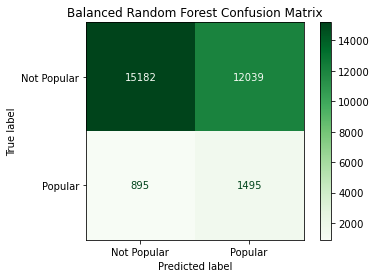

In [84]:
#Create confusion matrix
fig = plot_confusion_matrix(BRFC, X_test, y_test, display_labels=['Not Popular', 'Popular'], cmap='Greens')
plt.title('Balanced Random Forest Confusion Matrix')
plt.show()

### Random Forest/SMOTE

In [85]:
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.25, stratify=over_y)

In [86]:
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=100, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
scores3 = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)

In [87]:
three_f1_score = mean(scores3['test_f1'])
three_recall_score = mean(scores3['test_recall'])
three_precision_score = mean(scores3['test_precision'])

print('Mean F1: %.3f' % three_f1_score)
print('Mean Recall: %.3f' % three_recall_score)
print('Mean Precision: %.3f' % three_precision_score)

Mean F1: 0.902
Mean Recall: 0.917
Mean Precision: 0.886


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
print(classification_report(y_test, y_pred))
smrf_recall_score = metrics.recall_score(y_test, y_pred)
smrf_precision_score = metrics.precision_score(y_test, y_pred)
smrf_f1_score = metrics.f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     27221
           1       0.72      0.96      0.82      2390

    accuracy                           0.97     29611
   macro avg       0.86      0.96      0.90     29611
weighted avg       0.97      0.97      0.97     29611



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

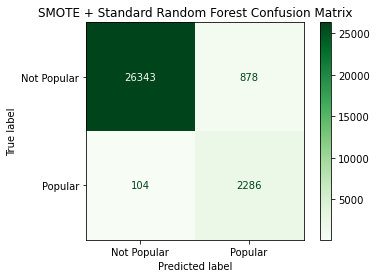

In [89]:
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['Not Popular', 'Popular'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

### XGBoost/SMOTE

In [90]:
xgboost_weight = (sum(spotifydf['Popularity_Type'] == 0)/sum(spotifydf['Popularity_Type'] == 1))
xgboost_weight

11.391922996442771

In [91]:
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.25, stratify=over_y)

In [92]:
#Build SMOTE SRF model
SMOTE_SXG = xgb_model = xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight = xgboost_weight, random_state=42)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
scores4 = cross_validate(SMOTE_SXG, over_X, over_y, scoring=scoring, cv=cv)

In [93]:
four_f1_score = mean(scores4['test_f1'])
four_recall_score = mean(scores4['test_recall'])
four_precision_score = mean(scores4['test_precision'])

print('Mean F1: %.3f' % four_f1_score)
print('Mean Recall: %.3f' % four_recall_score)
print('Mean Precision: %.3f' % four_precision_score)

Mean F1: 0.708
Mean Recall: 0.991
Mean Precision: 0.551


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
#Train SMOTE XG
SMOTE_SXG.fit(over_X_train, over_y_train)
#SMOTE XG prediction result
y_pred = SMOTE_SXG.predict(X_test)
print(classification_report(y_test, y_pred))
smxg_recall_score = metrics.recall_score(y_test, y_pred)
smxg_precision_score = metrics.precision_score(y_test, y_pred)
smxg_f1_score = metrics.f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.20      0.33     27221
           1       0.10      0.98      0.18      2390

    accuracy                           0.26     29611
   macro avg       0.54      0.59      0.25     29611
weighted avg       0.92      0.26      0.32     29611



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

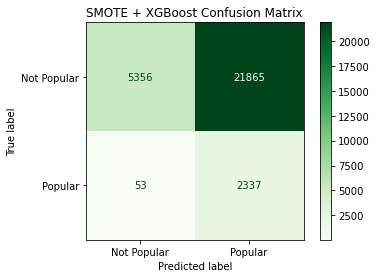

In [95]:
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SXG, X_test, y_test, display_labels=['Not Popular', 'Popular'], cmap='Greens')
plt.title('SMOTE + XGBoost Confusion Matrix')
plt.show()

### Ensemble Model

In [96]:
from sklearn.ensemble import VotingClassifier
estimators = []
estimators.append(('smxg', SMOTE_SXG))
estimators.append(('smrf', SMOTE_SRF))
ensemble_model = VotingClassifier(estimators, voting='soft', weights=[0.40,0.60])
ensemble_model.fit(over_X_train, over_y_train)

# Predicting the Test set results
y_pred = ensemble_model.predict(X_test)

In [97]:
print(classification_report(y_test, y_pred))
print()
print("Ensemble Accuracy Score:","{:,.2f}".format(metrics.accuracy_score(y_test, y_pred)*100),"%")
ens_recall_score = metrics.recall_score(y_test, y_pred)
ens_precision_score = metrics.precision_score(y_test, y_pred)
ens_f1_score = metrics.f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     27221
           1       0.38      0.98      0.54      2390

    accuracy                           0.87     29611
   macro avg       0.69      0.92      0.73     29611
weighted avg       0.95      0.87      0.89     29611




<IPython.core.display.Javascript object>

Ensemble Accuracy Score: 86.74 %


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Matrix

In [98]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: blue' if v else '' for v in is_max]
def highlight_mins(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

In [99]:
# create a dictionary that stores all the accuracy information
accuracy_dict = {}
for m in ["one","two", "three", 'four', "ens"]:
    accuracy_dict[m] = {}
    for f in ["precision"]:
        exec('accuracy_dict["{}"]["{}"] = {}_{}_score'.format(m, f, m, f))
    for f in ["recall"]:
        exec('accuracy_dict["{}"]["{}"] = {}_{}_score'.format(m, f, m, f))
    for f in ["f1"]:
        exec('accuracy_dict["{}"]["{}"] = {}_{}_score'.format(m, f, m, f))
        
#Accuracy Matrix
model_matrix=pd.DataFrame(accuracy_dict).rename(columns={"one":"Random Forest", 
                                           "two":"Balanced Random Forest",
                                                       "three": "Smote RF",
                                                        "four": "Smote XGBoost",
                                                        'ens':'Ensemble Model'}, 
                                   index={"precision":"Precision",
                                         "recall":"Recall",
                                        "f1":"F1 Score"})
model_matrix = model_matrix.applymap(lambda x: f"{x*100:.2f}%").style.set_caption("Model Matrix").apply(highlight_max, axis=1)
model_matrix

,Random Forest,Balanced Random Forest,Smote RF,Smote XGBoost,Ensemble Model
Precision,63.33%,11.20%,88.65%,55.12%,37.66%
Recall,7.14%,63.28%,91.71%,99.09%,98.16%
F1 Score,12.83%,19.04%,90.15%,70.84%,54.44%
